In [ ]:
# !pip install matplotlib
# !pip install seaborn
# !pip install numpy
# !pip install pandas
# !pip install pyodbc
# !pip install nltk
# !pip install re
# !pip install sklearn
# !pip install statsmodels

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import pyodbc
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import joblib

In [2]:
# Configuração da conexão com o banco de dados
server = 'xxx'
database = 'xxx'
username = 'xxx'
password = 'xxx'
driver = '{ODBC Driver 13 for SQL Server}'
tabela = 'xxx.dbo.Relato_clientes'
conn_str = f'DRIVER={{ODBC Driver 13 for SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}'
connection = pyodbc.connect(conn_str)

# Consulta para obter os relatos
relatos_query = f"SELECT [id_pedido],[id_tema],[id_produto],[id_problema],[relato] FROM {tabela}"
df = pd.read_sql(relatos_query, connection)

In [5]:
df = df.dropna(subset=['relato'])

In [ ]:
df.head()

In [ ]:
# Visao geral do problema
df.shape

In [ ]:
df.id_pedido.value_counts()

In [ ]:
df.id_tema.value_counts()

In [ ]:
df.id_produto.value_counts()

In [ ]:
df.id_problema.value_counts()

<AxesSubplot:>

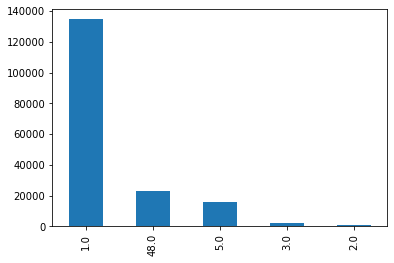

In [12]:
df.id_pedido.value_counts().plot(kind='bar')

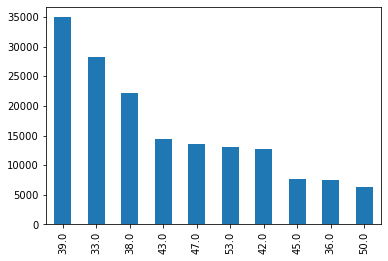

In [13]:
df['id_tema'].value_counts().head(10).plot(kind='bar')
plt.show()

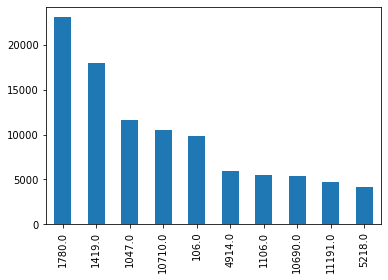

In [14]:
df['id_produto'].value_counts().head(10).plot(kind='bar')
plt.show()

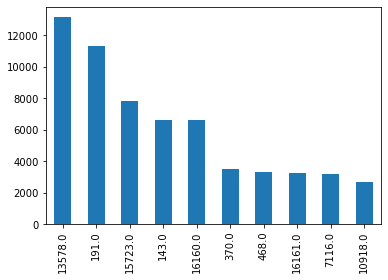

In [15]:
df['id_problema'].value_counts().head(10).plot(kind='bar')
plt.show()

# LIMPEZA

In [ ]:
# Remover números e caracteres especiais:
import re

def remover_numeros_caracteres_especiais(texto):
    texto_limpo = re.sub(r'[\dº&$:]+', '', texto)
    return texto_limpo.strip()

remover_numeros_caracteres_especiais(df.iloc[0].relato)

In [17]:
df['relato'] = df['relato'].apply(remover_numeros_caracteres_especiais)

In [ ]:
df.relato.head()

# NORMALIZAÇÃO

In [19]:
# Reduzir para minusculo
df['relato'] = df.relato.str.lower()

In [20]:
# Tokenizar
def tokenizar_com_regex(texto):
  regex = r'\w+'
  return re.findall(regex,texto)

df['RELATO_TNK'] = df.relato.apply(tokenizar_com_regex)

In [ ]:
df['RELATO_TNK']

In [22]:
padrao_regex = r'\b\w*x\w*x\w*\b'
count = 0 
for x,j in df.iterrows():
    
    for i in j['RELATO_TNK']:
        if re.match(padrao_regex, i):
            count = count + 1
            # print(i)
            # print(j['RELATO_TNK'].index(i))
            j['RELATO_TNK'].pop(j['RELATO_TNK'].index(i))

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Definir stopwords adicionais
additional_stopwords = ['XX', 'XXX', 'dia', '.no', '0800', '2020', '2021', '2022', '2023', '2024', '2025', '2026', '2027', '2028', '2029', '2030', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, '!', '?', '.', ',', ';', ':', '(', ')', '[', ']', '{', '}', "'", '"', '-', '_', '+', '=', '*', '/', '\\', '@', '#', '$', '%', '&', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '#', '@']

# Adicionar as stopwords adicionais à lista existente
stop_words = set(stopwords.words('portuguese'))
stop_words.update(additional_stopwords)

def remover_stopwords(words):
    return [word for word in words if word not in stop_words]

In [24]:
df['RELATO_TNK'] = df.RELATO_TNK.apply(remover_stopwords)

In [26]:
def normalizar_texto(texto):
  return remover_stopwords(tokenizar_com_regex(
      remover_numeros_caracteres_especiais(texto.lower())))

In [27]:
df['RELATO_TNK'] = df.relato.apply(normalizar_texto)

In [ ]:
df['RELATO_TNK']

# CRIAÇÃO DA AMOSTRA

In [ ]:
tamanho_amostra = 0.2 

df_amostra = df.sample(frac=tamanho_amostra, random_state=42)  # O parâmetro random_state garante a reprodutibilidade da amostra

# Verificar o tamanho da amostra
print("Tamanho da amostra:", len(df_amostra))

In [ ]:
df_amostra.shape

<AxesSubplot:>

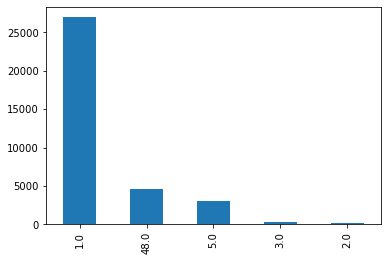

In [86]:
df_amostra.id_pedido.value_counts().plot(kind='bar')

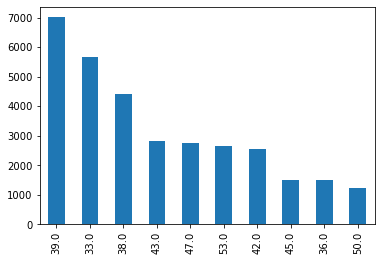

In [87]:
df_amostra['id_tema'].value_counts().head(10).plot(kind='bar')
plt.show()

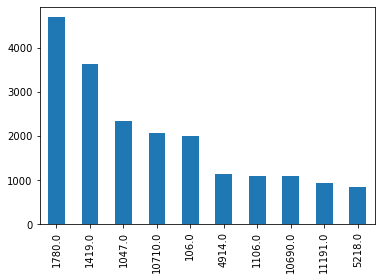

In [88]:
df_amostra['id_produto'].value_counts().head(10).plot(kind='bar')
plt.show()

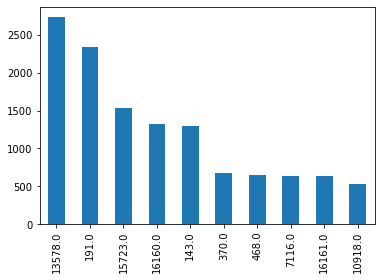

In [89]:
df_amostra['id_problema'].value_counts().head(10).plot(kind='bar')
plt.show()

In [ ]:
df_amostra.head()

In [33]:
from collections import Counter

df_classes_agrupadas = df_amostra.groupby('id_pedido')['RELATO_TNK'].sum().reset_index()

In [ ]:
df_classes_agrupadas

In [36]:
df_classes_agrupadas['frequencia_palavras'] = df_classes_agrupadas.RELATO_TNK.apply(Counter)

df_classes_agrupadas['palavras_mais_frequentes'] = df_classes_agrupadas.apply(lambda row: row['frequencia_palavras'].most_common(30), axis=1)

In [ ]:
df_classes_agrupadas['palavras_mais_frequentes']

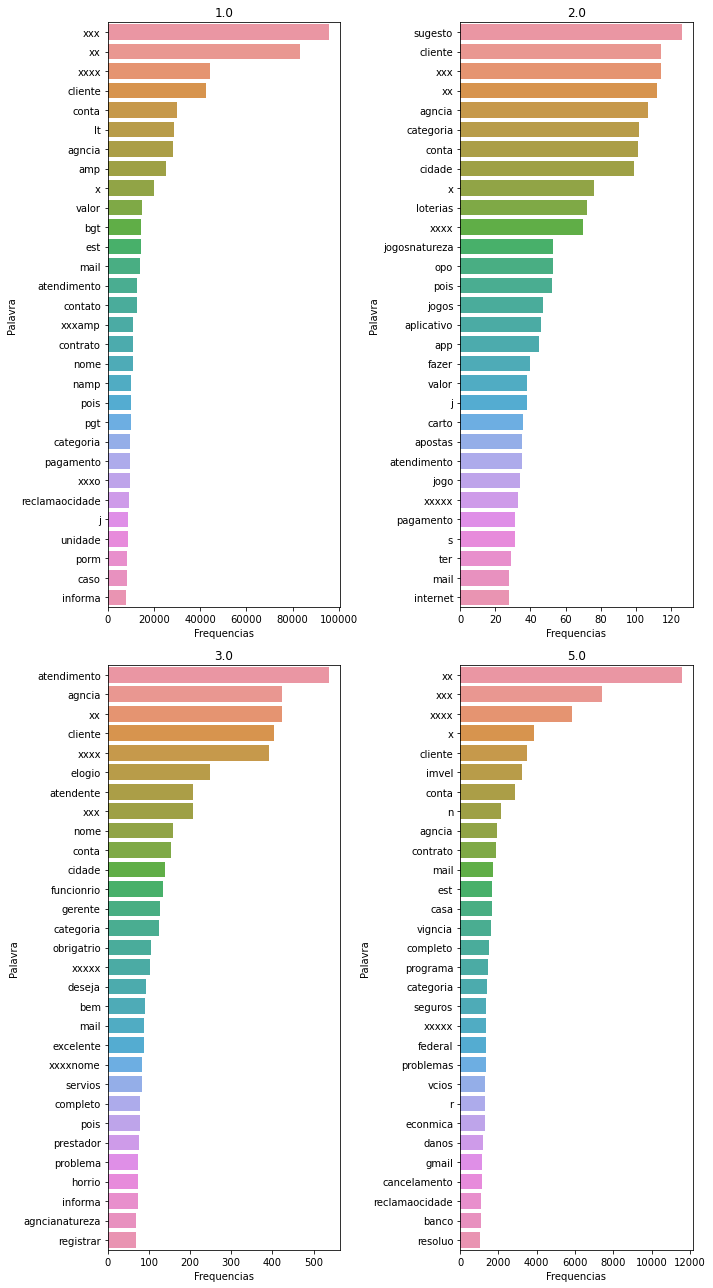

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 18))
areas = df_classes_agrupadas.id_pedido.unique()[:5]


for ax, id_pedido in zip(axes.flatten(), areas):
  words, frequencies = zip(*df_classes_agrupadas[df_classes_agrupadas.id_pedido==id_pedido].palavras_mais_frequentes.values[0])
  df2 = pd.DataFrame({'Palavra': words, 'Frequencias': frequencies})
  sns.barplot(y='Palavra', x='Frequencias', data=df2, orient = 'h', ax=ax)
  ax.set_title(id_pedido)  # Defina o título de cada subplot

# Ajuste o layout dos subplots
plt.tight_layout()

plt.show()

In [39]:
df_classes_agrupadas_tema = df_amostra.groupby('id_tema')['RELATO_TNK'].sum().reset_index()

In [ ]:
df_classes_agrupadas_tema

In [41]:
df_classes_agrupadas_tema['frequencia_palavras'] = df_classes_agrupadas_tema.RELATO_TNK.apply(Counter)

df_classes_agrupadas_tema['palavras_mais_frequentes'] = df_classes_agrupadas_tema.apply(lambda row: row['frequencia_palavras'].most_common(30), axis=1)

In [ ]:
df_classes_agrupadas_tema['palavras_mais_frequentes']

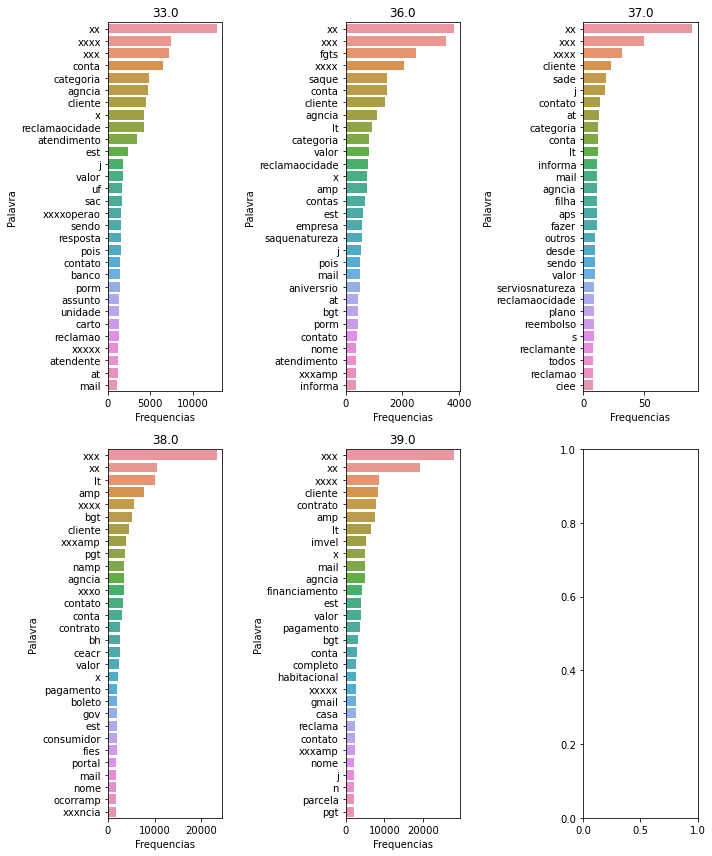

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 12))

# Obtenha as 5 classes mais numerosas dentro da coluna 'id_pedido'
top_classes = df_classes_agrupadas_tema.groupby('id_tema').size().nlargest(5).index

for ax, id_tema in zip(axes.flatten(), top_classes):
    words, frequencies = zip(*df_classes_agrupadas_tema[df_classes_agrupadas_tema.id_tema == id_tema].palavras_mais_frequentes.values[0])
    df2 = pd.DataFrame({'Palavra': words, 'Frequencias': frequencies})
    sns.barplot(y='Palavra', x='Frequencias', data=df2, orient='h', ax=ax)
    ax.set_title(id_tema)  # Defina o título de cada subplot

# Ajuste o layout dos subplots
plt.tight_layout()

plt.show()

In [44]:
df_classes_agrupadas_produto = df_amostra.groupby('id_produto')['RELATO_TNK'].sum().reset_index()

In [ ]:
df_classes_agrupadas_produto

In [46]:
df_classes_agrupadas_produto['frequencia_palavras'] = df_classes_agrupadas_produto.RELATO_TNK.apply(Counter)

df_classes_agrupadas_produto['palavras_mais_frequentes'] = df_classes_agrupadas_produto.apply(lambda row: row['frequencia_palavras'].most_common(30), axis=1)

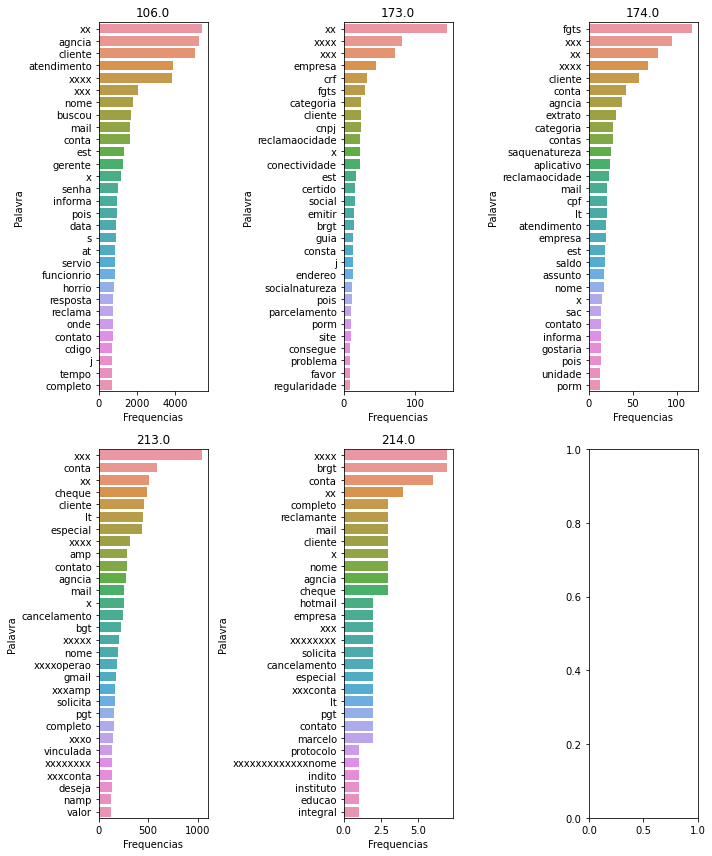

In [47]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 12))

# Obtenha as 5 classes mais numerosas dentro da coluna 'id_pedido'
top_classes = df_classes_agrupadas_produto.groupby('id_produto').size().nlargest(5).index

for ax, id_produto in zip(axes.flatten(), top_classes):
    words, frequencies = zip(*df_classes_agrupadas_produto[df_classes_agrupadas_produto.id_produto == id_produto].palavras_mais_frequentes.values[0])
    df2 = pd.DataFrame({'Palavra': words, 'Frequencias': frequencies})
    sns.barplot(y='Palavra', x='Frequencias', data=df2, orient='h', ax=ax)
    ax.set_title(id_produto)  # Defina o título de cada subplot

# Ajuste o layout dos subplots
plt.tight_layout()

plt.show()

In [48]:
df_classes_agrupadas_problema = df_amostra.groupby('id_problema')['RELATO_TNK'].sum().reset_index()

In [ ]:
df_classes_agrupadas_problema

In [50]:
df_classes_agrupadas_problema['frequencia_palavras'] = df_classes_agrupadas_problema.RELATO_TNK.apply(Counter)

df_classes_agrupadas_problema['palavras_mais_frequentes'] = df_classes_agrupadas_problema.apply(lambda row: row['frequencia_palavras'].most_common(30), axis=1)

In [ ]:
df_classes_agrupadas_problema['palavras_mais_frequentes']

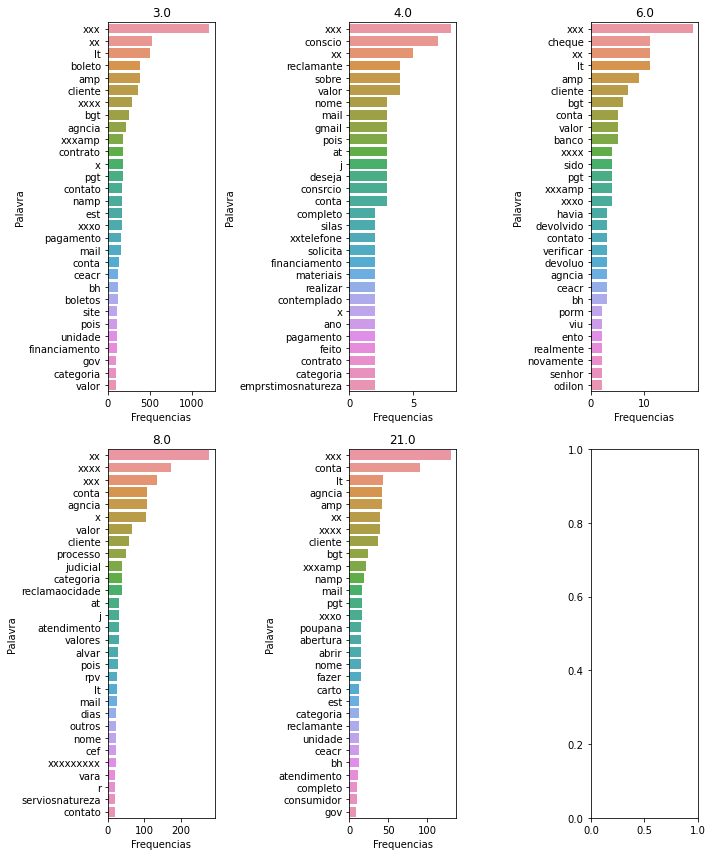

In [52]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 12))

# Obtenha as 5 classes mais numerosas dentro da coluna 'id_pedido'
top_classes = df_classes_agrupadas_problema.groupby('id_problema').size().nlargest(5).index

for ax, id_problema in zip(axes.flatten(), top_classes):
    words, frequencies = zip(*df_classes_agrupadas_problema[df_classes_agrupadas_problema.id_problema == id_problema].palavras_mais_frequentes.values[0])
    df2 = pd.DataFrame({'Palavra': words, 'Frequencias': frequencies})
    sns.barplot(y='Palavra', x='Frequencias', data=df2, orient='h', ax=ax)
    ax.set_title(id_problema)  # Defina o título de cada subplot

# Ajuste o layout dos subplots
plt.tight_layout()

plt.show()

# VETORIZAÇÃO DOS TEXTOS

In [ ]:
df_amostra['RELATO_TNK']

In [54]:
#Bag of Words
df_amostra['RELATO_TNK'] = df.apply(lambda row:' '.join(row['RELATO_TNK']), axis = 1)

vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(df_amostra['RELATO_TNK'])

In [ ]:
bow_matrix.shape

In [56]:
#TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_amostra['RELATO_TNK'])

In [ ]:
tfidf_matrix.shape

# Modelos

# Bag of Words - Dividir conjunto de dados de treinamento e teste

In [58]:
from sklearn.model_selection import train_test_split

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_matrix,
                                                    df_amostra.id_pedido,
                                                    test_size=0.2,
                                                    stratify=df_amostra.id_pedido)

# Bag of Words - Regressão Logística Multinomial

In [59]:
#Treinamento do modelo
nb_bow = MultinomialNB()
nb_bow.fit(X_train_bow, y_train_bow)

MultinomialNB()

In [60]:
#Teste do modelo e acurácia
train_predict = nb_bow.predict(X_test_bow)
metrics.accuracy_score(train_predict, y_test_bow)

0.7030983513359863

In [61]:
# Cria matriz de confusão
# soma das linhas é o valor real, soma das colunas é o valor predito
cm = confusion_matrix(y_test_bow, train_predict)

# Mostra a matriz de confusão
pd.DataFrame(cm, index=areas, columns=areas)

,1.0,2.0,3.0,5.0,48.0
1.0,3686,0,1,228,1479
2.0,14,0,0,0,20
3.0,34,0,14,0,24
5.0,60,0,0,404,145
48.0,69,0,0,15,843


In [62]:
# Normaliza a matriz de confsão dividindo cada célular pela somatória das respectivas linhas
cm_normalizada = cm / cm.sum(1)[:, None]

# Configura o pandas para mostrar somente duas casas decimais após o ponto
pd.options.display.float_format = '{:,.2f}'.format # Caso se queira visualizar todas as casas decimais, pode-se comentar esta linha

# Mostra a matriz de confusão normalizada
df_cm_normalizada = pd.DataFrame(cm_normalizada, index=areas, columns=areas)
df_cm_normalizada

,1.00,2.00,3.00,5.00,48.00
1.00,0.68,0.00,0.00,0.04,0.27
2.00,0.41,0.00,0.00,0.00,0.59
3.00,0.47,0.00,0.19,0.00,0.33
5.00,0.10,0.00,0.00,0.66,0.24
48.00,0.07,0.00,0.00,0.02,0.91


In [63]:
# Avaliação do desempenho do modelo
target_names = [str(area) for area in areas]
print(classification_report(y_test_bow, train_predict, target_names=target_names))

              precision    recall  f1-score   support

         1.0       0.95      0.68      0.80      5394
         2.0       0.00      0.00      0.00        34
         3.0       0.93      0.19      0.32        72
         5.0       0.62      0.66      0.64       609
        48.0       0.34      0.91      0.49       927

    accuracy                           0.70      7036
   macro avg       0.57      0.49      0.45      7036
weighted avg       0.84      0.70      0.73      7036



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Bag of Words - Random Forest

In [64]:
#Treinamento do modelo
rf_bow = RandomForestClassifier()
rf_bow.fit(X_train_bow, y_train_bow)

RandomForestClassifier()

In [65]:
#Teste do modelo e acurácia
train_predict = rf_bow.predict(X_test_bow)
metrics.accuracy_score(train_predict, y_test_bow)

0.8419556566230812

In [66]:
# Cria matriz de confusão
# soma das linhas é o valor real, soma das colunas é o valor predito
cm = confusion_matrix(y_test_bow, train_predict)

# Mostra a matriz de confusão
pd.DataFrame(cm, index=areas, columns=areas)

,1.00,2.00,3.00,5.00,48.00
1.00,5214,0,1,75,104
2.00,30,0,0,0,4
3.00,46,0,24,0,2
5.00,141,0,0,443,25
48.00,638,0,4,42,243


In [67]:
# Normaliza a matriz de confsão dividindo cada célular pela somatória das respectivas linhas
cm_normalizada = cm / cm.sum(1)[:, None]

# Configura o pandas para mostrar somente duas casas decimais após o ponto
pd.options.display.float_format = '{:,.2f}'.format # Caso se queira visualizar todas as casas decimais, pode-se comentar esta linha

# Mostra a matriz de confusão normalizada
df_cm_normalizada = pd.DataFrame(cm_normalizada, index=areas, columns=areas)
df_cm_normalizada

,1.00,2.00,3.00,5.00,48.00
1.00,0.97,0.00,0.00,0.01,0.02
2.00,0.88,0.00,0.00,0.00,0.12
3.00,0.64,0.00,0.33,0.00,0.03
5.00,0.23,0.00,0.00,0.73,0.04
48.00,0.69,0.00,0.00,0.05,0.26


In [68]:
# Avaliação do desempenho do modelo
target_names = [str(area) for area in areas]
print(classification_report(y_test_bow, train_predict, target_names=target_names))

              precision    recall  f1-score   support

         1.0       0.86      0.97      0.91      5394
         2.0       0.00      0.00      0.00        34
         3.0       0.83      0.33      0.48        72
         5.0       0.79      0.73      0.76       609
        48.0       0.64      0.26      0.37       927

    accuracy                           0.84      7036
   macro avg       0.62      0.46      0.50      7036
weighted avg       0.82      0.84      0.82      7036



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TFIDF - Dividir conjunto de dados de treinamento e teste

In [69]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix,
                                                    df_amostra.id_pedido,
                                                    test_size=0.2,
                                                    stratify=df_amostra.id_pedido)

# TFIDF - Regressão Logística Multinomial

In [70]:
#Treinamento do modelo
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [71]:
#Teste do modelo e acurácia
train_predict = nb.predict(X_test)
metrics.accuracy_score(train_predict, y_test)

0.7988914155770324

In [72]:
# Cria matriz de confusão
# soma das linhas é o valor real, soma das colunas é o valor predito
cm = confusion_matrix(y_test, train_predict)

# Mostra a matriz de confusão
pd.DataFrame(cm, index=areas, columns=areas)

,1.00,2.00,3.00,5.00,48.00
1.00,5380,0,0,13,1
2.00,34,0,0,0,0
3.00,72,0,0,0,0
5.00,378,0,0,223,8
48.00,897,0,0,12,18


In [73]:
# Normaliza a matriz de confsão dividindo cada célular pela somatória das respectivas linhas
cm_normalizada = cm / cm.sum(1)[:, None]

# Configura o pandas para mostrar somente duas casas decimais após o ponto
pd.options.display.float_format = '{:,.2f}'.format # Caso se queira visualizar todas as casas decimais, pode-se comentar esta linha

# Mostra a matriz de confusão normalizada
df_cm_normalizada = pd.DataFrame(cm_normalizada, index=areas, columns=areas)
df_cm_normalizada

,1.00,2.00,3.00,5.00,48.00
1.00,1.00,0.00,0.00,0.00,0.00
2.00,1.00,0.00,0.00,0.00,0.00
3.00,1.00,0.00,0.00,0.00,0.00
5.00,0.62,0.00,0.00,0.37,0.01
48.00,0.97,0.00,0.00,0.01,0.02


In [74]:
# Avaliação do desempenho do modelo
target_names = [str(area) for area in areas]
print(classification_report(y_test_bow, train_predict, target_names=target_names))

              precision    recall  f1-score   support

         1.0       0.77      0.96      0.85      5394
         2.0       0.00      0.00      0.00        34
         3.0       0.00      0.00      0.00        72
         5.0       0.08      0.03      0.05       609
        48.0       0.19      0.01      0.01       927

    accuracy                           0.74      7036
   macro avg       0.21      0.20      0.18      7036
weighted avg       0.62      0.74      0.66      7036



C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dell\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# TFIDF - Random Forest

In [75]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [76]:
train_predict = rf.predict(X_test)
metrics.accuracy_score(train_predict, y_test)

0.8393973848777715

In [77]:
# Cria matriz de confusão
# soma das linhas é o valor real, soma das colunas é o valor predito
cm = confusion_matrix(y_test, train_predict)

# Mostra a matriz de confusão
pd.DataFrame(cm, index=areas, columns=areas)

,1.00,2.00,3.00,5.00,48.00
1.00,5257,0,0,54,83
2.00,33,1,0,0,0
3.00,45,0,22,0,5
5.00,151,0,0,441,17
48.00,687,0,0,55,185


In [78]:
# Normaliza a matriz de confsão dividindo cada célular pela somatória das respectivas linhas
cm_normalizada = cm / cm.sum(1)[:, None]

# Configura o pandas para mostrar somente duas casas decimais após o ponto
pd.options.display.float_format = '{:,.2f}'.format # Caso se queira visualizar todas as casas decimais, pode-se comentar esta linha

# Mostra a matriz de confusão normalizada
df_cm_normalizada = pd.DataFrame(cm_normalizada, index=areas, columns=areas)
df_cm_normalizada

,1.00,2.00,3.00,5.00,48.00
1.00,0.97,0.00,0.00,0.01,0.02
2.00,0.97,0.03,0.00,0.00,0.00
3.00,0.62,0.00,0.31,0.00,0.07
5.00,0.25,0.00,0.00,0.72,0.03
48.00,0.74,0.00,0.00,0.06,0.20


In [79]:
# Avaliação do desempenho do modelo
target_names = [str(area) for area in areas]
print(classification_report(y_test_bow, train_predict, target_names=target_names))

              precision    recall  f1-score   support

         1.0       0.77      0.88      0.82      5394
         2.0       0.00      0.00      0.00        34
         3.0       0.00      0.00      0.00        72
         5.0       0.09      0.08      0.08       609
        48.0       0.15      0.05      0.07       927

    accuracy                           0.69      7036
   macro avg       0.20      0.20      0.19      7036
weighted avg       0.61      0.69      0.64      7036



# Resultado Bag of Words - Regressão Logística Multinomial

In [90]:
import pandas as pd
import numpy as np
import joblib

# Carregar os modelos treinados e o vetorizador
modelo = nb_bow
vetorizador = vectorizer

# Supondo que você já tenha as funções definidas: remover_numeros_caracteres_especiais, tokenizar_com_regex,
# remover_stopwords e normalizar_texto
def remover_stopwords(tokens):
    tokens_sem_stopwords = [token for token in tokens if token not in stop_words]
    texto_sem_stopwords = " ".join(tokens_sem_stopwords)
    return texto_sem_stopwords

# Função para prever a variável resposta usando os modelos treinados
def prever_variavel_resposta(texto):
    # Tratamento do texto do relato
    texto_tratado = remover_numeros_caracteres_especiais(texto)
    tokens = tokenizar_com_regex(texto_tratado)
    tokens_sem_stopwords = remover_stopwords(tokens)
    texto_normalizado = normalizar_texto(tokens_sem_stopwords)
    
    # Converter o texto tratado em um DataFrame para realizar a previsão
    novo_relato = pd.DataFrame({'Texto': [texto_normalizado]})

    # Realizar a vetorização do texto usando o vetorizador
    novo_relato_vetorizado = vetorizador.transform(novo_relato['Texto'])

    # Realizar a previsão usando o modelo treinado
    previsao = modelo.predict(novo_relato_vetorizado)
    
    # Retornar a previsão
    return previsao

# Exemplo de uso
novo_relato = input("Digite o novo relato: ")
variavel_resposta_prevista = prever_variavel_resposta(novo_relato)
print(variavel_resposta_prevista)


Digite o novo relato: Cliente fez uma compra e, como no veio a fatura, ligou solicitando esta. No contato, foi informado de que o carto estava cancelado, e que a divida  estava com uma central de cobrana que teria que ligar para a central.  Ao ligar constatou uma divida parcelada e que teria que fazer um acordo.  No sabe o motivo do cancelamento e porque sua dvida estava com essa central.
[1.]


# Resultado Bag of Words - Random Forest

In [91]:
import pandas as pd
import numpy as np
import joblib

# Carregar os modelos treinados e o vetorizador
modelo = rf_bow
vetorizador = vectorizer

# Supondo que você já tenha as funções definidas: remover_numeros_caracteres_especiais, tokenizar_com_regex,
# remover_stopwords e normalizar_texto
def remover_stopwords(tokens):
    tokens_sem_stopwords = [token for token in tokens if token not in stop_words]
    texto_sem_stopwords = " ".join(tokens_sem_stopwords)
    return texto_sem_stopwords

# Função para prever a variável resposta usando os modelos treinados
def prever_variavel_resposta(texto):
    # Tratamento do texto do relato
    texto_tratado = remover_numeros_caracteres_especiais(texto)
    tokens = tokenizar_com_regex(texto_tratado)
    tokens_sem_stopwords = remover_stopwords(tokens)
    texto_normalizado = normalizar_texto(tokens_sem_stopwords)
    
    # Converter o texto tratado em um DataFrame para realizar a previsão
    novo_relato = pd.DataFrame({'Texto': [texto_normalizado]})

    # Realizar a vetorização do texto usando o vetorizador
    novo_relato_vetorizado = vetorizador.transform(novo_relato['Texto'])

    # Realizar a previsão usando o modelo treinado
    previsao = modelo.predict(novo_relato_vetorizado)
    
    # Retornar a previsão
    return previsao

# Exemplo de uso
novo_relato = input("Digite o novo relato: ")
variavel_resposta_prevista = prever_variavel_resposta(novo_relato)
print(variavel_resposta_prevista)


Digite o novo relato: Cliente fez uma compra e, como no veio a fatura, ligou solicitando esta. No contato, foi informado de que o carto estava cancelado, e que a divida  estava com uma central de cobrana que teria que ligar para a central.  Ao ligar constatou uma divida parcelada e que teria que fazer um acordo.  No sabe o motivo do cancelamento e porque sua dvida estava com essa central.
[1.]


# Resultado TFIDF - Regressão Logística Multinomial

In [92]:
import pandas as pd
import numpy as np
import joblib

# Carregar os modelos treinados e o vetorizador
modelo = nb
vetorizador = tfidf_vectorizer

# Supondo que você já tenha as funções definidas: remover_numeros_caracteres_especiais, tokenizar_com_regex,
# remover_stopwords e normalizar_texto
def remover_stopwords(tokens):
    tokens_sem_stopwords = [token for token in tokens if token not in stop_words]
    texto_sem_stopwords = " ".join(tokens_sem_stopwords)
    return texto_sem_stopwords

# Função para prever a variável resposta usando os modelos treinados
def prever_variavel_resposta(texto):
    # Tratamento do texto do relato
    texto_tratado = remover_numeros_caracteres_especiais(texto)
    tokens = tokenizar_com_regex(texto_tratado)
    tokens_sem_stopwords = remover_stopwords(tokens)
    texto_normalizado = normalizar_texto(tokens_sem_stopwords)
    
    # Converter o texto tratado em um DataFrame para realizar a previsão
    novo_relato = pd.DataFrame({'Texto': [texto_normalizado]})

    # Realizar a vetorização do texto usando o vetorizador
    novo_relato_vetorizado = vetorizador.transform(novo_relato['Texto'])

    # Realizar a previsão usando o modelo treinado
    previsao = modelo.predict(novo_relato_vetorizado)
    
    # Retornar a previsão
    return previsao

# Exemplo de uso
novo_relato = input("Digite o novo relato: ")
variavel_resposta_prevista = prever_variavel_resposta(novo_relato)
print(variavel_resposta_prevista)


Digite o novo relato: Cliente fez uma compra e, como no veio a fatura, ligou solicitando esta. No contato, foi informado de que o carto estava cancelado, e que a divida  estava com uma central de cobrana que teria que ligar para a central.  Ao ligar constatou uma divida parcelada e que teria que fazer um acordo.  No sabe o motivo do cancelamento e porque sua dvida estava com essa central.
[1.]


# Resultado TFIDF - Random Forest

In [93]:
import pandas as pd
import numpy as np
import joblib

# Carregar os modelos treinados e o vetorizador
modelo = rf
vetorizador = tfidf_vectorizer

# Supondo que você já tenha as funções definidas: remover_numeros_caracteres_especiais, tokenizar_com_regex,
# remover_stopwords e normalizar_texto
def remover_stopwords(tokens):
    tokens_sem_stopwords = [token for token in tokens if token not in stop_words]
    texto_sem_stopwords = " ".join(tokens_sem_stopwords)
    return texto_sem_stopwords

# Função para prever a variável resposta usando os modelos treinados
def prever_variavel_resposta(texto):
    # Tratamento do texto do relato
    texto_tratado = remover_numeros_caracteres_especiais(texto)
    tokens = tokenizar_com_regex(texto_tratado)
    tokens_sem_stopwords = remover_stopwords(tokens)
    texto_normalizado = normalizar_texto(tokens_sem_stopwords)
    
    # Converter o texto tratado em um DataFrame para realizar a previsão
    novo_relato = pd.DataFrame({'Texto': [texto_normalizado]})

    # Realizar a vetorização do texto usando o vetorizador
    novo_relato_vetorizado = vetorizador.transform(novo_relato['Texto'])

    # Realizar a previsão usando o modelo treinado
    previsao = modelo.predict(novo_relato_vetorizado)
    
    # Retornar a previsão
    return previsao

# Exemplo de uso
novo_relato = input("Digite o novo relato: ")
variavel_resposta_prevista = prever_variavel_resposta(novo_relato)
print(variavel_resposta_prevista)


Digite o novo relato: Cliente fez uma compra e, como no veio a fatura, ligou solicitando esta. No contato, foi informado de que o carto estava cancelado, e que a divida  estava com uma central de cobrana que teria que ligar para a central.  Ao ligar constatou uma divida parcelada e que teria que fazer um acordo.  No sabe o motivo do cancelamento e porque sua dvida estava com essa central.
[1.]
